# Excersise in beta calculation using FRED API
In the following jupyter notebook I am looking at possibility of calculating beta (volatility measure) for US govt. bonds

In [1]:
import numpy as np
import requests
import pandas as pd
from fred_key import fred_key
import matplotlib.pyplot as plt

In [2]:
api_key = fred_key

In [3]:
# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

'''
Get observation data from the FRED API
'''

# Assign endpoint
obs_endpoint = 'series/observations'

In [4]:
# Assign parameters
series_id = 'SP500'
start_date = '2013-11-11'
end_date = '2023-11-13'
ts_frequency = 'd'
ts_units = 'pc1'

In [5]:
obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    # 'frequency': ts_frequency
    # 'units': ts_units
}

# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)

In [6]:
# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
else:
    print('Failed to retrieve data. Status code:', response.status_code)
    

In [7]:
SP500 = obs_data.drop(['realtime_start','realtime_end'], axis = 1)

In [8]:
temp1= np.array(SP500['value'])

In [9]:
idx = np.array([])
for i, n in enumerate(temp1):
    if n == '.':
        idx = np.append(idx, i)
idx = idx.astype(int)
temp1 = np.delete(temp1,idx)

In [10]:
temp1 = temp1.astype(float)

In [11]:
temp2= temp1[1:]
temp3= temp1[:-1]

In [12]:
SP500 = SP500.drop(idx, axis=0)
SP500 = SP500.drop(0, axis=0)

In [13]:
SP500.reset_index(drop=True, inplace=True)
SP500

,date,value
0,2013-11-19,1787.87
1,2013-11-20,1781.37
2,2013-11-21,1795.85
3,2013-11-22,1804.76
4,2013-11-25,1802.48
...,...,...
2508,2023-11-07,4378.38
2509,2023-11-08,4382.78
2510,2023-11-09,4347.35
2511,2023-11-10,4415.24


In [14]:
SP500_2 = SP500.drop(index=range(0, 366))

In [15]:
temp4 = temp1[367:]
temp5 = temp1[:-367]

In [16]:
SP500['returnSP500S'] = ((((temp3-temp2)/temp3+1)**365) - 1) * 100
SP500_2['returnSP500L'] = ((temp4-temp5)/temp5)*100
##SP500[] = np.array((temp1 - temp1[0])/temp1[0]*100)
##temp4 = np.delete[0]
##SP500['returnSP500L'] = temp4


In [17]:
series_id = 'DGS10'
start_date = '2013-11-11'
end_date = '2023-11-13'
ts_frequency = 'd'
ts_units = 'pc1'

obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    # 'frequency': ts_frequency
    # 'units': ts_units
}

In [18]:
# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)
# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
else:
    print('Failed to retrieve data. Status code:', response.status_code)

In [19]:
bonds = obs_data

In [20]:
temp4 = np.array(bonds['value'])
idx = np.array([])
for i, n in enumerate(temp4):
    if n == '.':
        idx = np.append(idx, i)
idx = idx.astype(int)
temp4 = np.delete(temp4,idx)
temp4 = temp4.astype(float)

In [21]:
bonds = bonds.drop(idx, axis=0)

In [22]:
#bonds = bonds.drop(['realtime_start','realtime_end','value'], axis = 1)
bonds['value_B10'] = temp4

In [23]:
final = pd.merge(SP500_2, bonds, on='date', how = 'right')
final = final.drop(['realtime_start','realtime_end','value_y'], axis = 1)
final['SP500v'] =final['value_x'].astype(float)
final = final.drop('value_x',axis=1)
final.dropna(axis=0)

,date,returnSP500L,value_B10,SP500v
370,2015-05-06,16.110252,2.25,2080.15
371,2015-05-07,16.787015,2.18,2088.00
372,2015-05-08,18.790594,2.16,2116.10
373,2015-05-11,17.233065,2.28,2105.33
374,2015-05-12,16.310202,2.28,2099.12
...,...,...,...,...
2498,2023-11-07,10.182573,4.58,4378.38
2499,2023-11-08,11.196302,4.49,4382.78
2500,2023-11-09,9.264765,4.62,4347.35
2501,2023-11-10,8.807642,4.61,4415.24


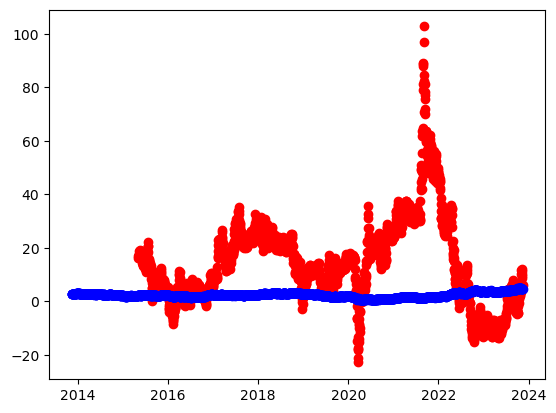

In [24]:
plt.scatter(final['date'],final['returnSP500L'], color='r')
plt.scatter(final['date'],final['value_B10'], color='b')

In [26]:
cov = final.cov(min_periods=None, ddof=1, numeric_only=True)
cov

,returnSP500L,value_B10,SP500v
returnSP500L,251.993478,-6.245177,3657.027631
value_B10,-6.245177,0.737123,149.098489
SP500v,3657.027631,149.098489,722581.943234


In [27]:
var1 = final['returnSP500L'].var(axis=0, skipna=True, ddof=1, numeric_only=False)
##var2= final['returnSP500L'].var(axis=0, skipna=True, ddof=1, numeric_only=False)

In [28]:
cov['returnSP500L']/var1

returnSP500L     1.000000
value_B10       -0.024783
SP500v          14.512390
Name: returnSP500L, dtype: float64